In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
import netCDF4 as nc

import sys
sys.path.append('../src/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
from TamocWrapper import run_tamoc_sbm, parse_tamoc_sbm_results, setup_ambient_profile, get_bubble_diameter

In [9]:
# Get data from GOTM file
d = nc.Dataset('/home/torn/Projects/GOTM/cases/nns_annual/nns_annual.nc')

for k, v in d.variables.items():
    print(f'{k}, \t {v.long_name}')

time, 	 time
lon, 	 longitude
lat, 	 latitude
zeta, 	 sea surface elevation
u_taus, 	 surface friction velocity
Hice, 	 fake ice thickness
u10, 	 10m wind (x)
v10, 	 10m wind (y)
airt, 	 2m air temperature
airp, 	 air pressure
hum, 	 relative humidity
es, 	 saturation water vapor pressure
ea, 	 actual water vapor presure
qs, 	 saturation specific humidity
qa, 	 specific humidity
rhoa, 	 air density
cloud, 	 cloud cover
albedo, 	 albedo
precip, 	 precipitation
evap, 	 evaporation
int_precip, 	 integrated precipitation
int_evap, 	 integrated evaporation
int_swr, 	 integrated short wave radiation
int_heat, 	 integrated surface heat fluxes
int_total, 	 integrated total surface heat exchange
I_0, 	 incoming short wave radiation
qh, 	 sensible heat flux
qe, 	 latent heat flux
ql, 	 net longwave radiation
heat, 	 net surface heat flux
tx, 	 wind stress (x)
ty, 	 wind stress (y)
sst, 	 sea surface temperature - in-situ
sst_obs, 	 observed sea surface temperature
sss, 	 sea surface salinity
mld

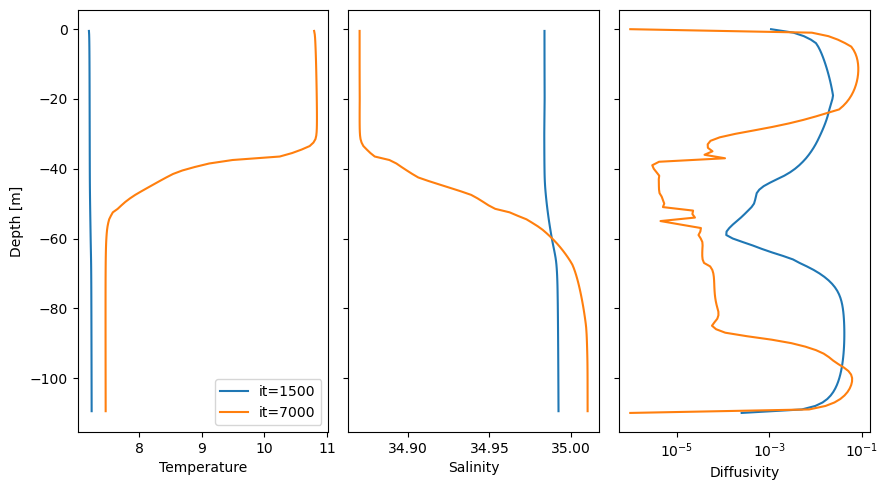

In [24]:
# Get data from GOTM file
d = nc.Dataset('/home/torn/Projects/GOTM/cases/nns_annual/nns_annual.nc')
K_gotm = d.variables['nus'][:,:,0,0]
z_gotm = d.variables['z' ][0,:,0,0]
zi_gotm = d.variables['zi' ][0,:,0,0]
T_gotm = d.variables['temp_i'][:,:,0,0]
S_gotm = d.variables['salt_p'][:,:,0,0]

# Deal with zero at boundaries by linear interpolation
K_gotm[:,0]  = np.maximum(1e-6, K_gotm[:,1] - (K_gotm[:,2]-K_gotm[:,1]))
K_gotm[:,-1] = np.maximum(1e-6, K_gotm[:,-2] - (K_gotm[:,-3]-K_gotm[:,-2]))
assert np.all(K_gotm > 0)


fig, ax = plt.subplots(ncols=3, figsize=(9,5), sharey=True)
for it in [1500, 7000]:

    ax[0].plot(T_gotm[it,:], z_gotm, label=f'it={it}')
    ax[1].plot(S_gotm[it,:], z_gotm)
    ax[2].plot(K_gotm[it,:], zi_gotm)

ax[2].set_xscale('log')

ax[0].legend()
ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('Temperature')
ax[1].set_xlabel('Salinity')
ax[2].set_xlabel('Diffusivity')
plt.tight_layout()

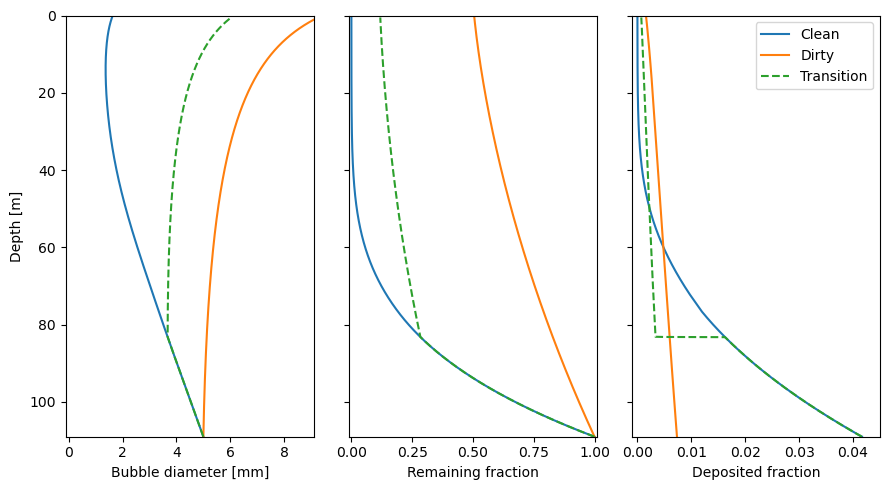

In [62]:
# Get data from GOTM file
ds = nc.Dataset('/home/torn/Projects/GOTM/cases/nns_annual/nns_annual.nc')

it = 1500

z_gotm = np.abs(ds.variables['z' ][0,:,0,0])
T_gotm = ds.variables['temp_i'][it,:,0,0]
S_gotm = ds.variables['salt_p'][it,:,0,0]

profile = setup_ambient_profile(z_gotm, T_gotm, S_gotm)


# Release depth, in meters
z0 = 109
# Initial diameter, in meters
d0 = 5e-3


fig, ax = plt.subplots(ncols=3, figsize=(9,5), sharey=True)

for t_hyd, label, lt in zip([np.inf, 0, 100], ['Clean', 'Dirty', 'Transition'], ['-', '-', '--']):
    bub, sbm = run_tamoc_sbm(z0, d0, profile, t_hyd=t_hyd)
    depth, remaining, deposited, direct = parse_tamoc_sbm_results(sbm, z0)

    z, d = get_bubble_diameter(bub, sbm, profile)

    ax[0].plot(1000*d, z, lt)
    ax[1].plot(remaining[:-1], depth, lt)
    ax[2].plot(deposited, depth, lt, label=label)

ax[0].set_ylim(z0, 0)
ax[0].set_xlim(-0.1, 9.1)
ax[1].set_xlim(-0.01, 1.01)
ax[2].set_xlim(-0.001, 0.045)

ax[2].legend()
ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('Bubble diameter [mm]')
ax[1].set_xlabel('Remaining fraction')
ax[2].set_xlabel('Deposited fraction')
plt.tight_layout()

plt.savefig('bubble_example.png', dpi=240)
plt.savefig('bubble_example.pdf')